## **OBJECTIVE : Training classification model to find the model which would optimally classify legitimate and malicious domains.**

Our dataset consist of 450k samples of legitimate and malicious domain urls,in this notebook we'll first explore the dataset and then train a classifier model which would optimally predict phishing and legitimate urls.

**NOTE** : Our dataset is Imbalanced. We'll use SMOTE to oversample dataset.

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Exploratory Data Analysis**

We have 21 features out of which 18 features were extracted from dataset in the previous notebook, the 'results' feature is the ground truth while the remaining 2 features ('url' , 'label') are only there for reference and can will be removed during training of the model.

In [2]:
# loading out dataset from previous notebook
urldata = pd.read_csv("/content/drive/MyDrive/Url_Processed.csv")

# droping "Unnamed: 0" as its unncessary feature
urldata.drop("Unnamed: 0",axis=1,inplace=True)

urldata.head(10)

,url,label,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,0,0,0,...,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,0,0,0,...,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,0,0,0,...,2,0,1,1,1,0,20,0,1,1
5,https://www.reddit.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,-1
6,https://www.yahoo.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
7,https://www.google.co.in,benign,0,24,16,0,0,0,0,0,...,3,0,1,1,1,0,18,0,1,1
8,https://www.qq.com,benign,0,18,10,0,0,0,0,0,...,2,0,1,1,1,0,13,0,1,1
9,https://www.amazon.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1


In [3]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   url              450176 non-null  object
 1   label            450176 non-null  object
 2   result           450176 non-null  int64 
 3   url_length       450176 non-null  int64 
 4   hostname_length  450176 non-null  int64 
 5   path_length      450176 non-null  int64 
 6   fd_length        450176 non-null  int64 
 7   count-           450176 non-null  int64 
 8   count@           450176 non-null  int64 
 9   count?           450176 non-null  int64 
 10  count%           450176 non-null  int64 
 11  count.           450176 non-null  int64 
 12  count=           450176 non-null  int64 
 13  count-http       450176 non-null  int64 
 14  count-https      450176 non-null  int64 
 15  count-www        450176 non-null  int64 
 16  count-digits     450176 non-null  int64 
 17  count-lett

benign       345738
malicious    104438
Name: label, dtype: int64


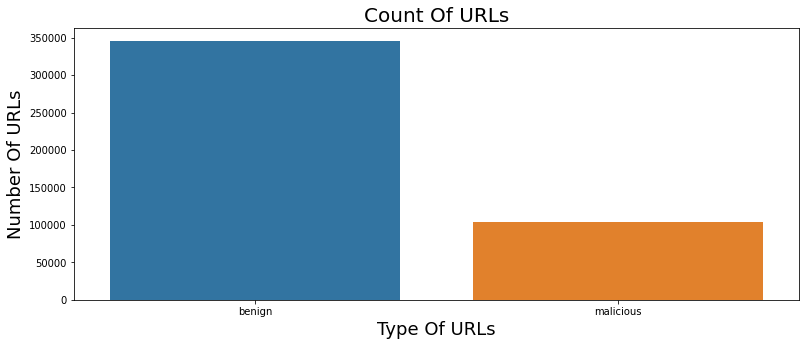

In [4]:
# Lets find how many malicious and non-malicious samples we have
i = urldata["label"].value_counts()
print(i)

plt.figure(figsize=(13,5))
sns.countplot(x='label',data=urldata)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)
plt.show()

<AxesSubplot: >

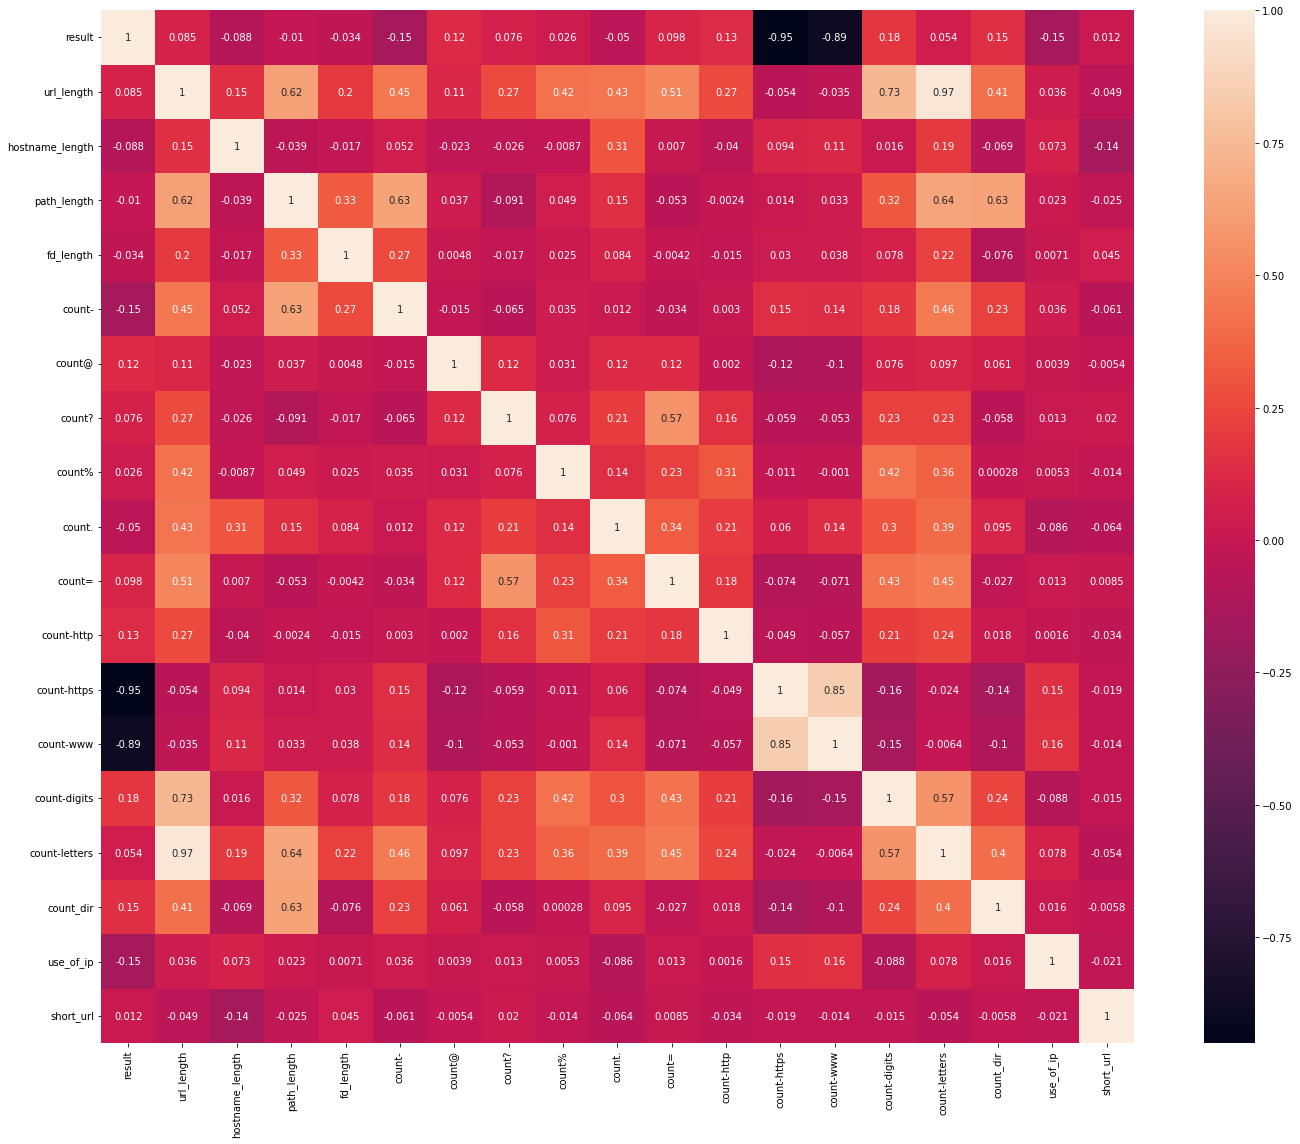

In [5]:

#Correlation Heatmap
corrmat = urldata.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

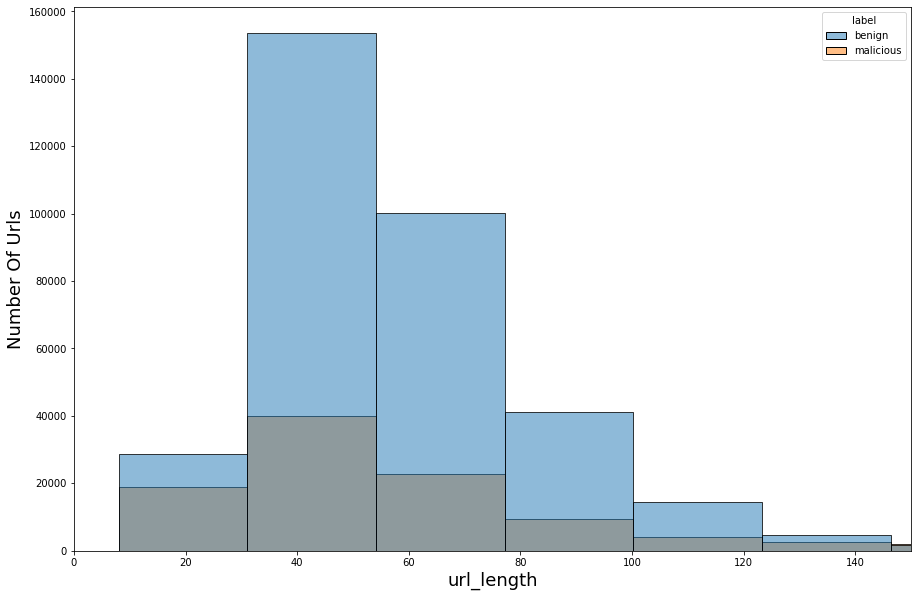

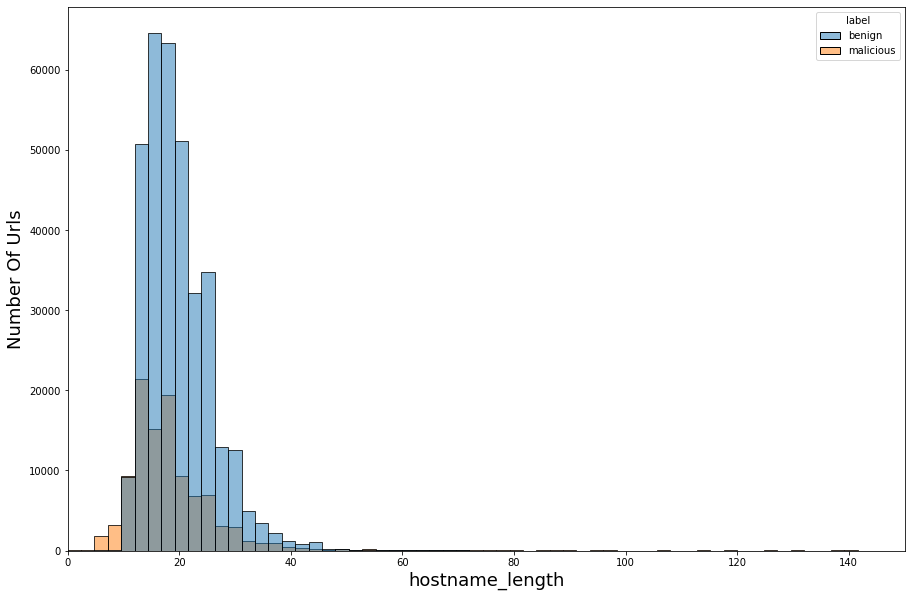

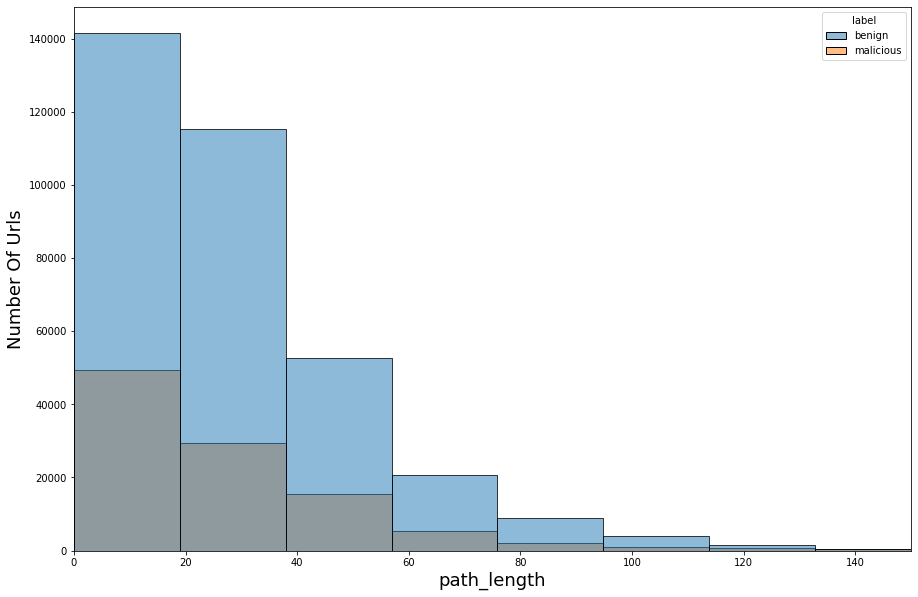

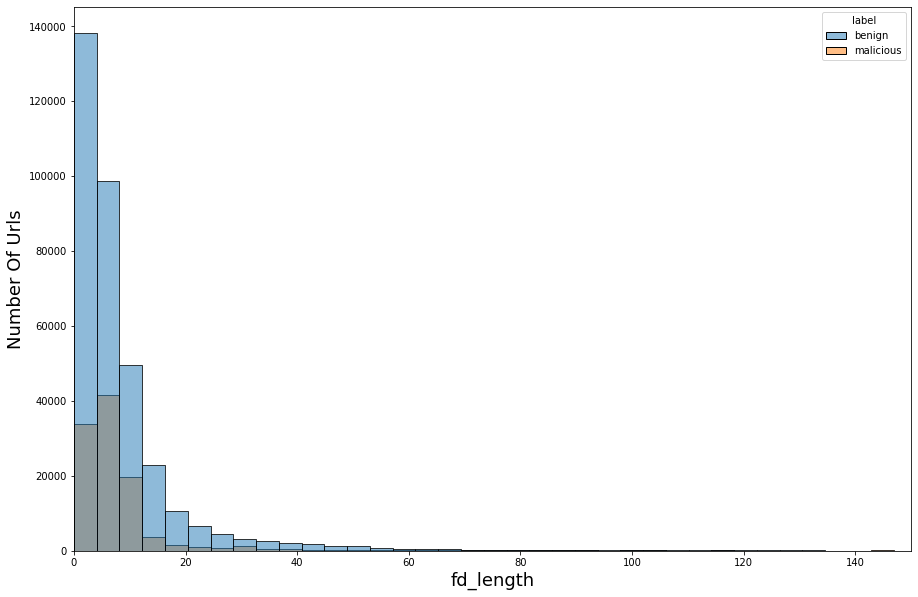

In [6]:
# setting plot sizes
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10

# plotting distrubutions
features = list(urldata.columns) # list of feature names
features.remove("url")
features.remove("result")

hist_features = ["url_length","hostname_length","path_length","fd_length"]

for i in hist_features:
   sns.histplot(data=urldata,x=i,bins=100,hue='label')
   plt.xlabel(i,fontsize=18)
   plt.ylabel("Number Of Urls",fontsize=18)
   plt.xlim(0,150)
   plt.show()

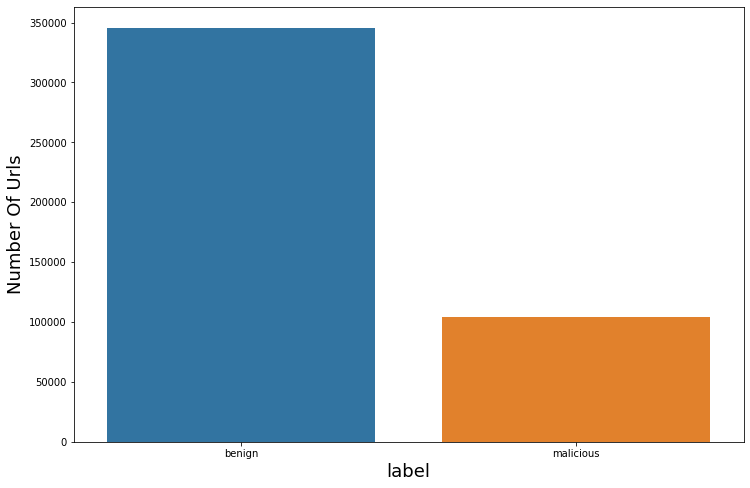

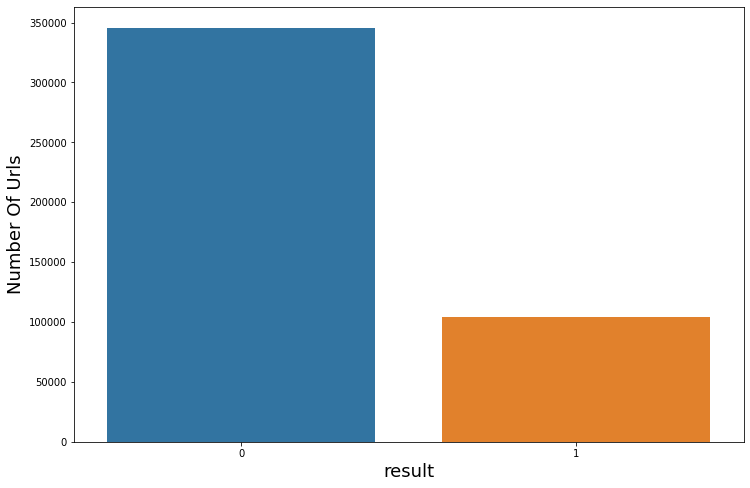

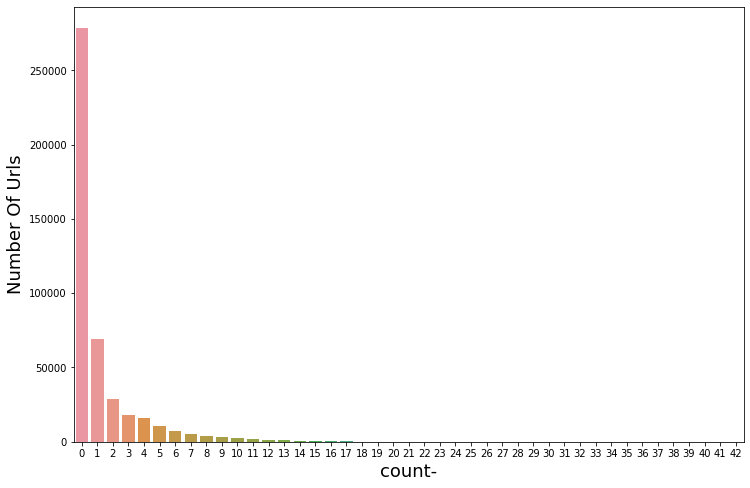

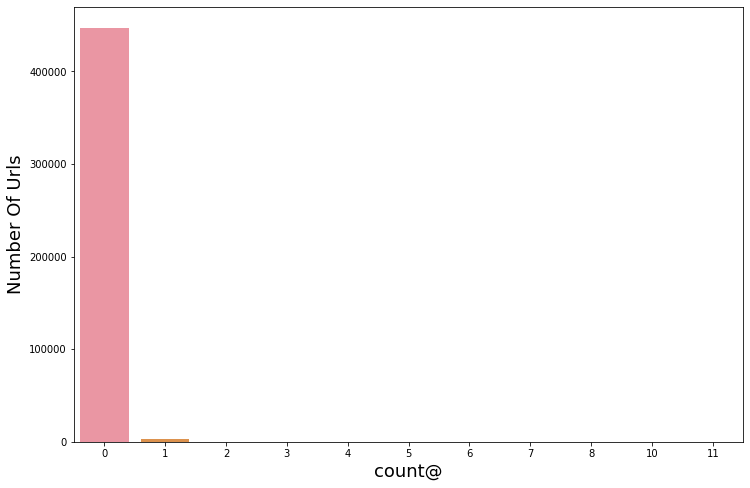

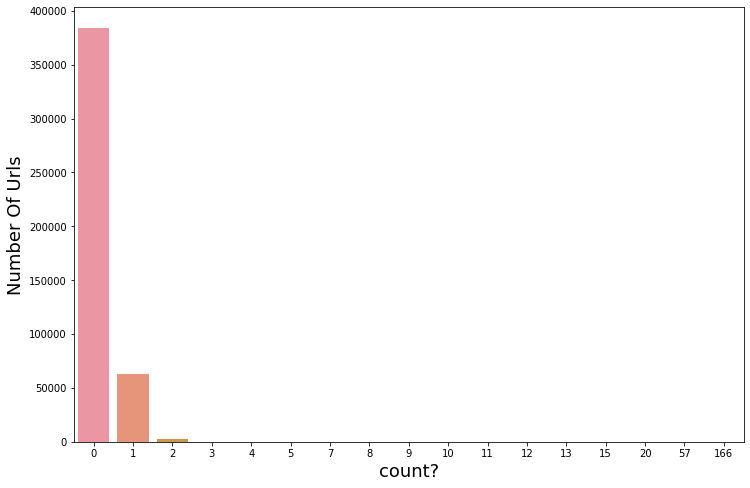

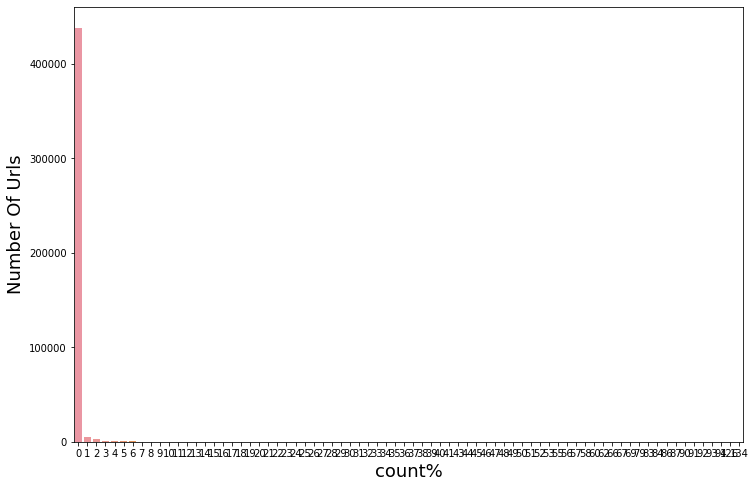

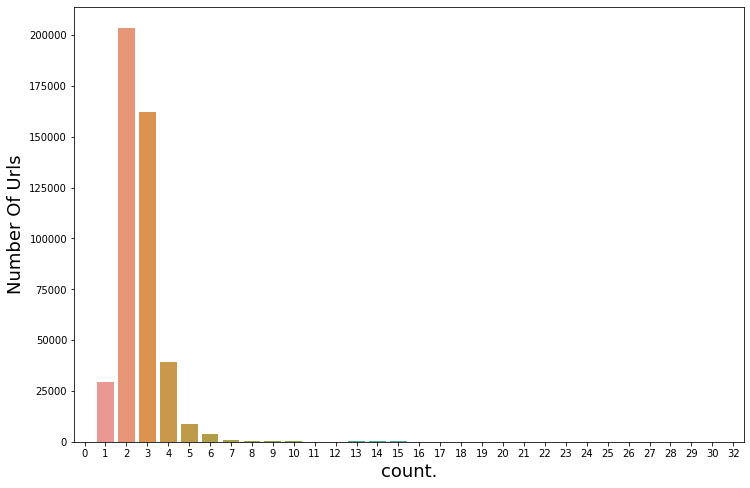

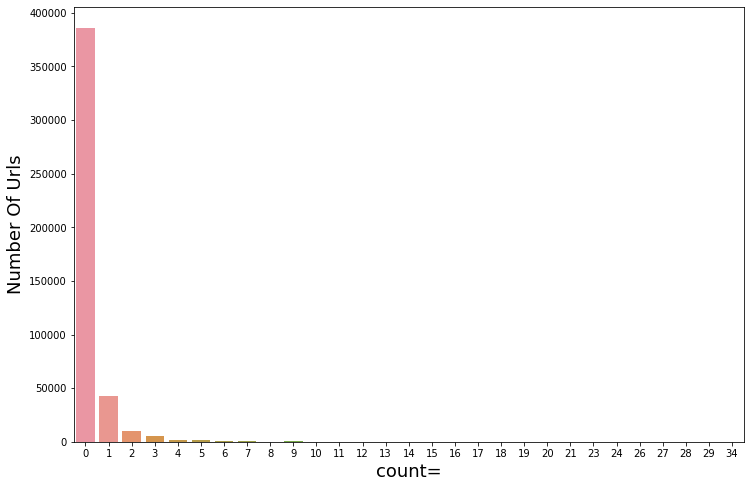

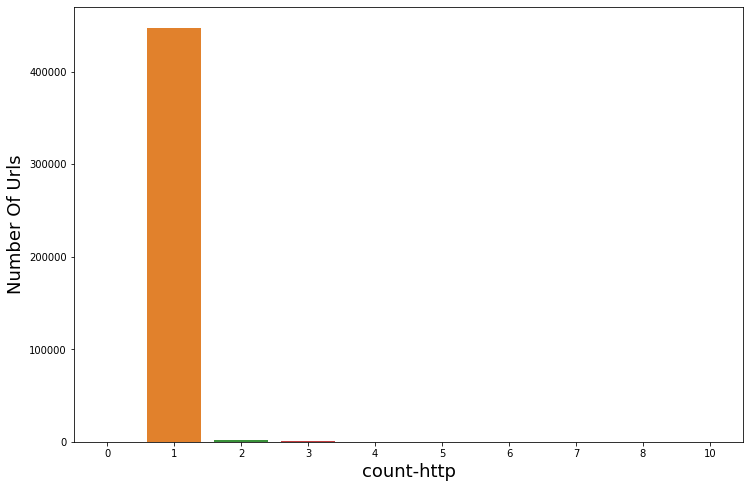

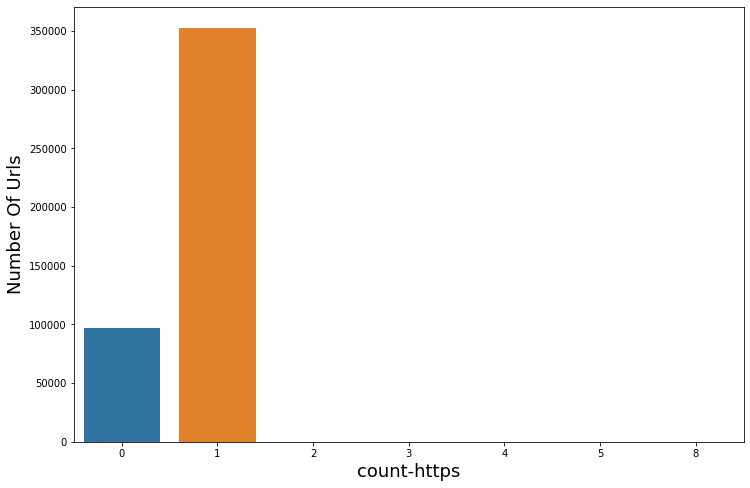

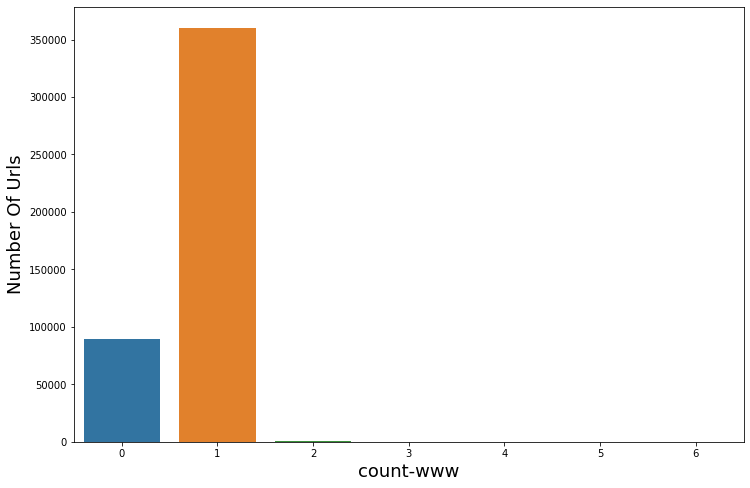

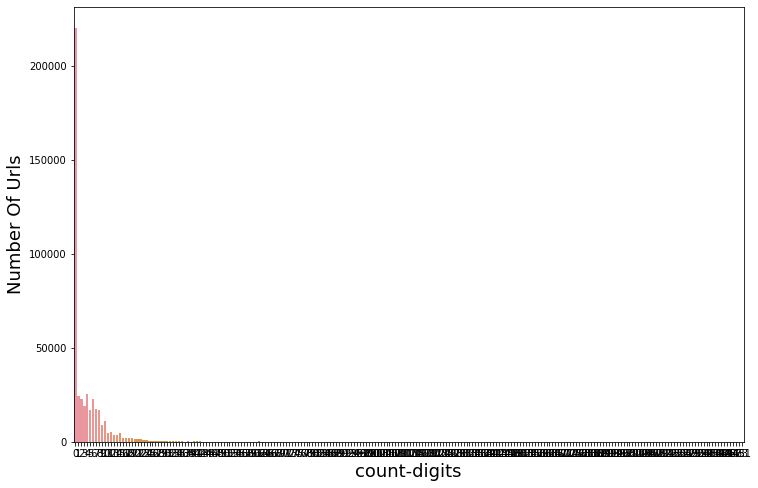

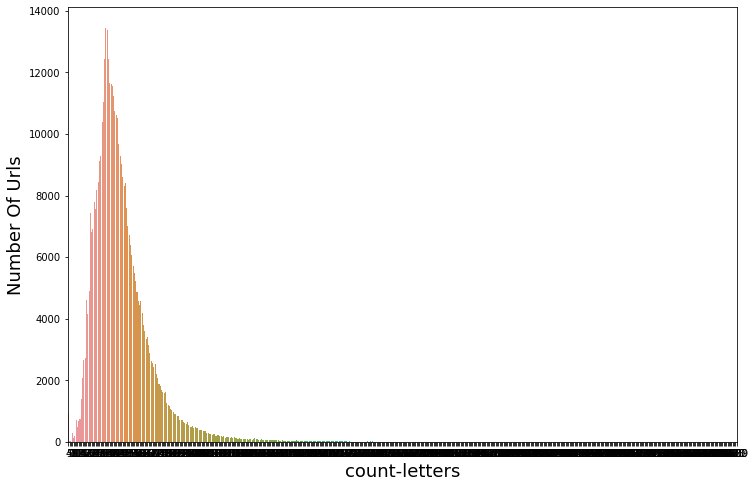

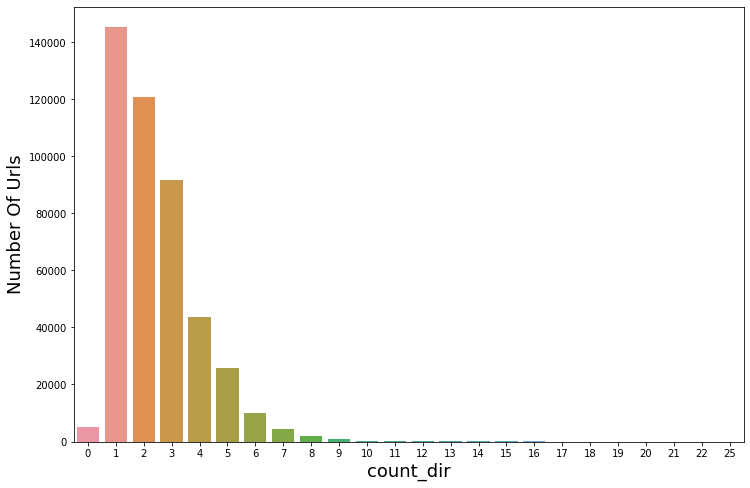

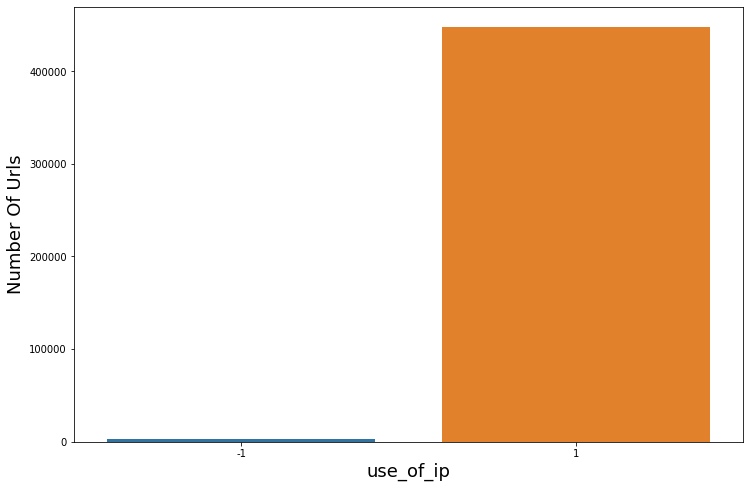

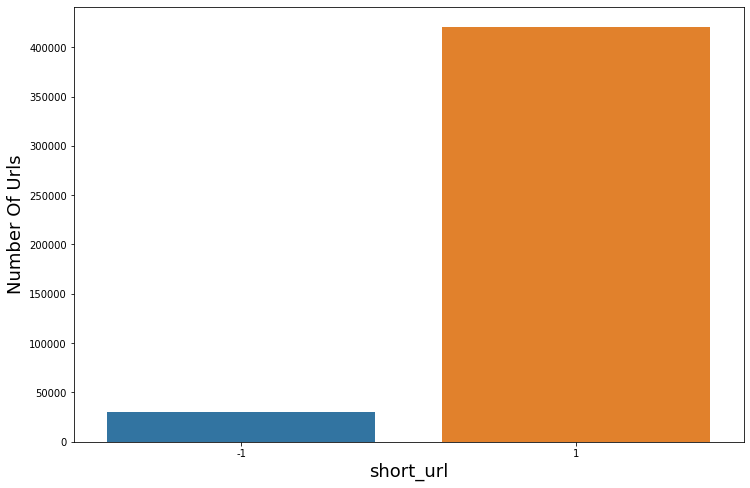

In [7]:
# plotting distrubutions

features = list(urldata.columns) # list of feature names
features.remove("url")

rcParams['figure.figsize'] = 12,8

for i in features:
   
   if i in hist_features:
     continue
   
   sns.countplot(x=i,data=urldata)
   plt.xlabel(i,fontsize=18)
   plt.ylabel("Number Of Urls",fontsize=18)
   plt.show()
  

# **Model Training**

Before training our models we'll split the data into train and test dataset. We'll train multiple models and choose the one which gives us the best validation-accuracy. This problem falls under "Binary classification" and the models we'll train are :
- Decision Tree
- Random Forest
- Naive Bayes
- Logistic Regression

### **Data Splitting**

We'll follow a 80:20 ratio for data splitting,where we use 80% of data for training and 20% for testing.

In [8]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,0,0,0,...,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,0,0,0,...,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,0,0,0,...,2,0,1,1,1,0,20,0,1,1


In [9]:
# remove uneccessary columns
urldata.drop(["url","label"],axis=1,inplace=True)

urldata.head()

,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,0,22,14,0,0,0,0,0,0,2,0,1,1,1,0,17,0,1,1
1,0,23,15,0,0,0,0,0,0,2,0,1,1,1,0,18,0,1,1
2,0,24,16,0,0,0,0,0,0,2,0,1,1,1,0,19,0,1,1
3,0,21,13,0,0,0,0,0,0,2,0,1,1,1,0,16,0,1,1
4,0,25,17,0,0,0,0,0,0,2,0,1,1,1,0,20,0,1,1


In [10]:
# NOTE : We'll use only lexical features for this notebook i,e not taking 'url_length' and 'short_url'

#Independent Variables
x = urldata[['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

#Dependent Variable
y = urldata['result']

In [11]:
# printing x
x.head()

,hostname_length,path_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip
0,14,0,0,0,0,0,0,2,0,1,1,1,0,17,0,1
1,15,0,0,0,0,0,0,2,0,1,1,1,0,18,0,1
2,16,0,0,0,0,0,0,2,0,1,1,1,0,19,0,1
3,13,0,0,0,0,0,0,2,0,1,1,1,0,16,0,1
4,17,0,0,0,0,0,0,2,0,1,1,1,0,20,0,1


In [12]:
# printing y
y.head()

0    0
1    0
2    0
3    0
4    0
Name: result, dtype: int64

#### **Oversampling Imbalanced Dataset**

During EDA we found that our dataset is Imbalanced,so we'll now use SMOTE method to oversample the dataset.

In [13]:
#Oversampling using SMOTE
from imblearn.over_sampling import SMOTE

x_sample, y_sample = SMOTE().fit_resample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

In [14]:
# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)

Size of x-sample : (691476, 16)
Size of y-sample : (691476, 1)


In [15]:
# DATA SPLITTING 

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size = 0.2)
print("Shape of x_train: ", x_train.shape)
print("Shape of x_valid: ", x_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_valid: ", y_test.shape)

Shape of x_train:  (553180, 16)
Shape of x_valid:  (138296, 16)
Shape of y_train:  (553180, 1)
Shape of y_valid:  (138296, 1)


In [16]:
# Creating holders to store the model performance results
ML_Model = []
acc_train = []
acc_test = []

#function to call for storing the results
def storeResults(model, a,b):
  ML_Model.append(model)
  acc_train.append(round(a, 4))
  acc_test.append(round(b, 4))

## **1] Decision Tree**

A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes).

In [17]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=7)

# start training the model
model.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=7)

#### **Model Performance Evaluation**

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# finding y_pred for train and test dataset
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# finding accuracy on train and test dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,y_pred_test)

print("Accuracy on Training dataset : ",round(train_acc,4))
print("Accuracy on Testing dataset : ",round(test_acc,4))

Accuracy on Training dataset :  0.9975
Accuracy on Testing dataset :  0.9974


In [19]:
# calculating other classification metrics
print(classification_report(y_pred_test,y_test,target_names=["legitimate","malicious"]))

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69208
   malicious       1.00      1.00      1.00     69088

    accuracy                           1.00    138296
   macro avg       1.00      1.00      1.00    138296
weighted avg       1.00      1.00      1.00    138296



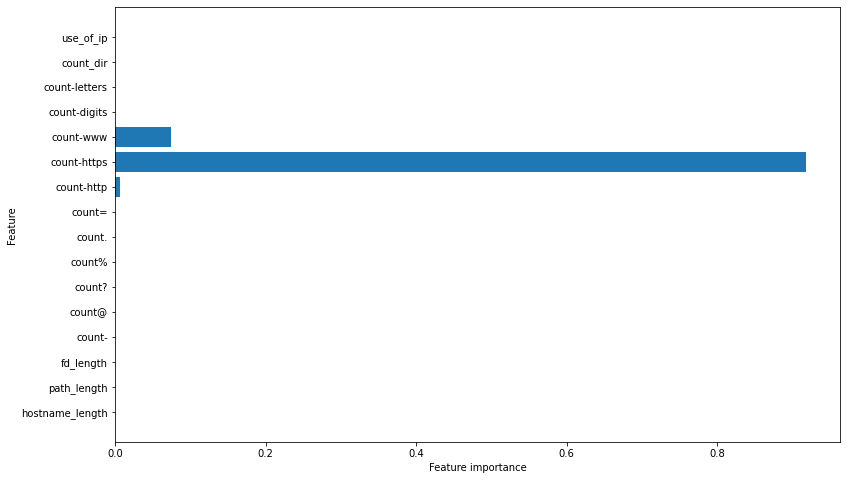

In [20]:
feature_names = ['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']

#checking the feature improtance in the model
plt.figure(figsize=(13,8))
n_features = x_train.shape[1]
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(n_features),feature_names)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [21]:
storeResults('Decision Tree', train_acc, test_acc)

## **2] Random Forest**
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=7)

# start training the model
model.fit(x_train,y_train)

<ipython-input-22-1b02d89a7a36>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


RandomForestClassifier(max_depth=7)

#### **Model Performance Evaluation**

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# finding y_pred for train and test dataset
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# finding accuracy on train and test dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,y_pred_test)

print("Accuracy on Training dataset : ",round(train_acc,4))
print("Accuracy on Testing dataset : ",round(test_acc,4))

Accuracy on Training dataset :  0.9974
Accuracy on Testing dataset :  0.9974


In [24]:
# calculating other classification metrics
print(classification_report(y_pred_test,y_test,target_names=["legitimate","malicious"]))

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69207
   malicious       1.00      1.00      1.00     69089

    accuracy                           1.00    138296
   macro avg       1.00      1.00      1.00    138296
weighted avg       1.00      1.00      1.00    138296



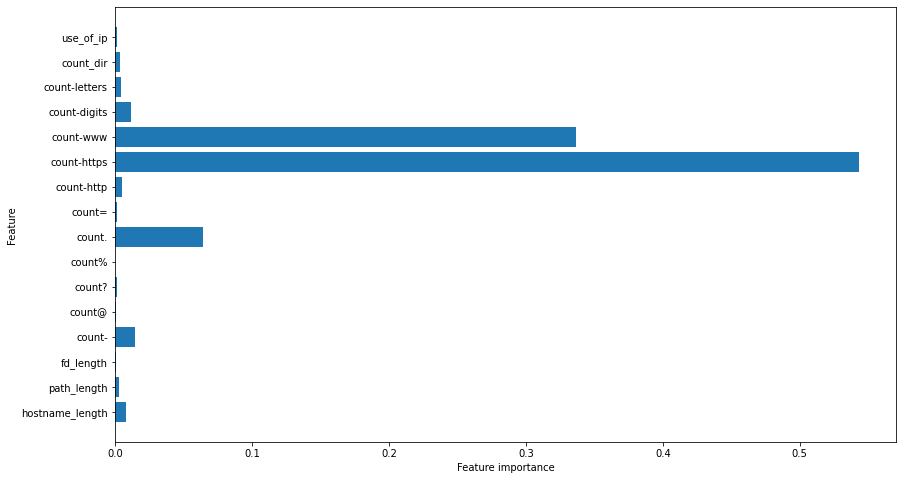

In [25]:
feature_names = ['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']

#checking the feature improtance in the model
plt.figure(figsize=(14,8))
n_features = x_train.shape[1]
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(n_features),feature_names)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [26]:
storeResults('Random Forest', train_acc, test_acc)

## **3] Naive Bayes**
Logistic regression is a calculation used to predict a binary outcome: either something happens, or does not. This can be exhibited as Yes/No, Pass/Fail, Alive/Dead, etc. 
Independent variables are analyzed to determine the binary outcome with the results falling into one of two categories. The independent variables can be categorical or numeric, but the dependent variable is always categorical.

In [27]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

# start training the model
model.fit(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

#### **Model Performance Evaluation**

In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# finding y_pred for train and test dataset
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# finding accuracy on train and test dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,y_pred_test)

print("Accuracy on Training dataset : ",round(train_acc,4))
print("Accuracy on Testing dataset : ",round(test_acc,4))

Accuracy on Training dataset :  0.9944
Accuracy on Testing dataset :  0.9943


In [29]:
# calculating other classification metrics
print(classification_report(y_pred_test,y_test,target_names=["legitimate","malicious"]))

              precision    recall  f1-score   support

  legitimate       0.99      1.00      0.99     68714
   malicious       1.00      0.99      0.99     69582

    accuracy                           0.99    138296
   macro avg       0.99      0.99      0.99    138296
weighted avg       0.99      0.99      0.99    138296



In [30]:
storeResults('Naive Bayes', train_acc, test_acc)

## **4] Logistic Regression**
Logistic regression is a calculation used to predict a binary outcome: either something happens, or does not. This can be exhibited as Yes/No, Pass/Fail, Alive/Dead, etc. 
Independent variables are analyzed to determine the binary outcome with the results falling into one of two categories. The independent variables can be categorical or numeric, but the dependent variable is always categorical.

In [31]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression

# instantiate the model
model = LogisticRegression()

model.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### **Model Performance Evaluation**

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# finding y_pred for train and test dataset
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# finding accuracy on train and test dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,y_pred_test)

print("Accuracy on Training dataset : ",round(train_acc,4))
print("Accuracy on Testing dataset : ",round(test_acc,4))

Accuracy on Training dataset :  0.9966
Accuracy on Testing dataset :  0.9967


In [33]:
# calculating other classification metrics
print(classification_report(y_pred_test,y_test,target_names=["legitimate","malicious"]))

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69269
   malicious       1.00      1.00      1.00     69027

    accuracy                           1.00    138296
   macro avg       1.00      1.00      1.00    138296
weighted avg       1.00      1.00      1.00    138296



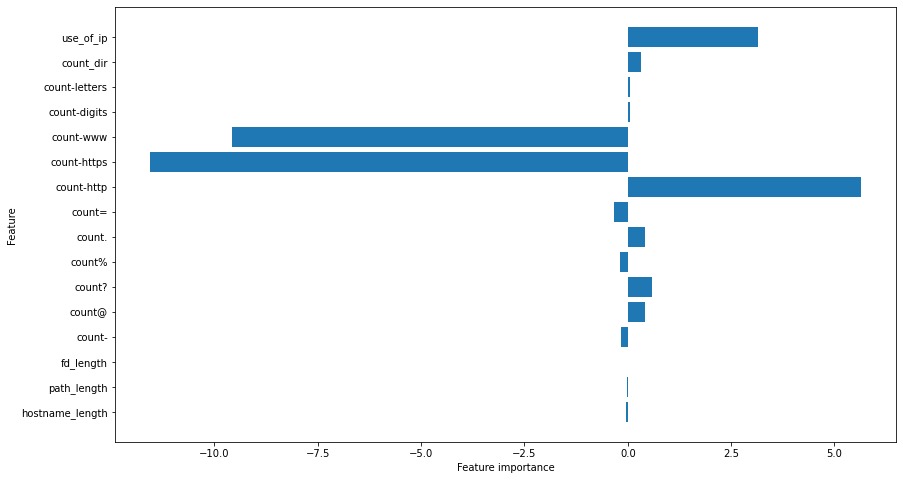

In [34]:
feature_names = ['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']

#checking the feature improtance in the model
plt.figure(figsize=(14,8))
n_features = x_train.shape[1]
plt.barh(range(n_features), model.coef_[0], align='center')
plt.yticks(np.arange(n_features),feature_names)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [35]:
storeResults('Logistic Regression', train_acc, test_acc)

In [36]:
#creating dataframe
results = pd.DataFrame({ 'ML Model': ML_Model,    
                         'Train Accuracy': acc_train,
                        'Test Accuracy': acc_test})
results

,ML Model,Train Accuracy,Test Accuracy
0,Decision Tree,0.9975,0.9974
1,Random Forest,0.9974,0.9974
2,Naive Bayes,0.9944,0.9943
3,Logistic Regression,0.9966,0.9967


In [37]:
results.sort_values(by=['Test Accuracy', 'Train Accuracy'], ascending=False)

,ML Model,Train Accuracy,Test Accuracy
0,Decision Tree,0.9975,0.9974
1,Random Forest,0.9974,0.9974
3,Logistic Regression,0.9966,0.9967
2,Naive Bayes,0.9944,0.9943


In [38]:
pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


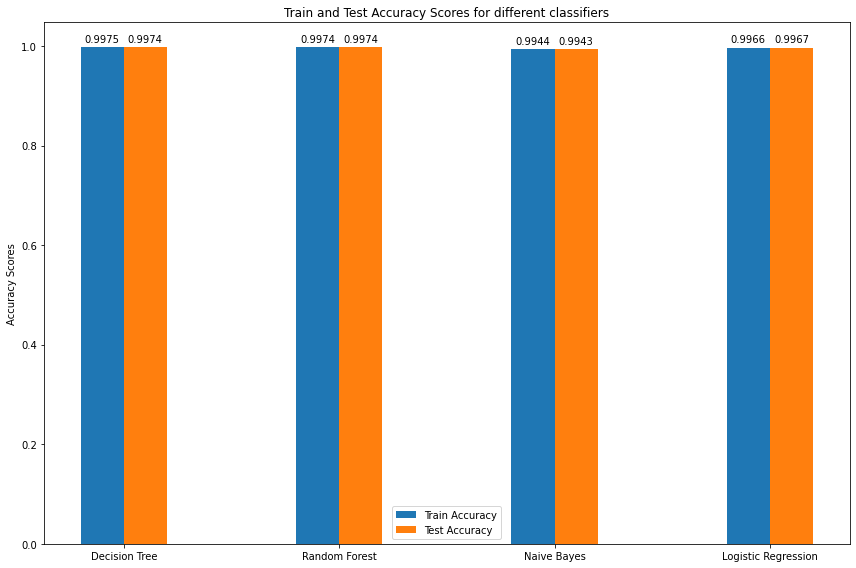

In [53]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'Logistic Regression']
train_accuracy = results['Train Accuracy']
test_accuracy = results['Test Accuracy']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracy, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, test_accuracy, width, label='Test Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Scores')
ax.set_title('Train and Test Accuracy Scores for different classifiers')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

As visible, both Random Forest and Decision  is giving the maximum accuracy for Test data but Decision Tree is giving more for Training data, so I'll go with Decision Tree model

In [40]:
model = DecisionTreeClassifier(max_depth=7)
model.fit(x_train,y_train)

import pickle
pickle.dump(model, open("/content/drive/MyDrive/DTClassifier.pickle.dat", "wb"))